In [1]:
%load_ext autoreload
%autoreload 2

from generative import dataset, utils, models
import jax
import jax.numpy as jnp
import optax
import orbax.checkpoint
from flax.training import orbax_utils
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct 

from tqdm import tqdm

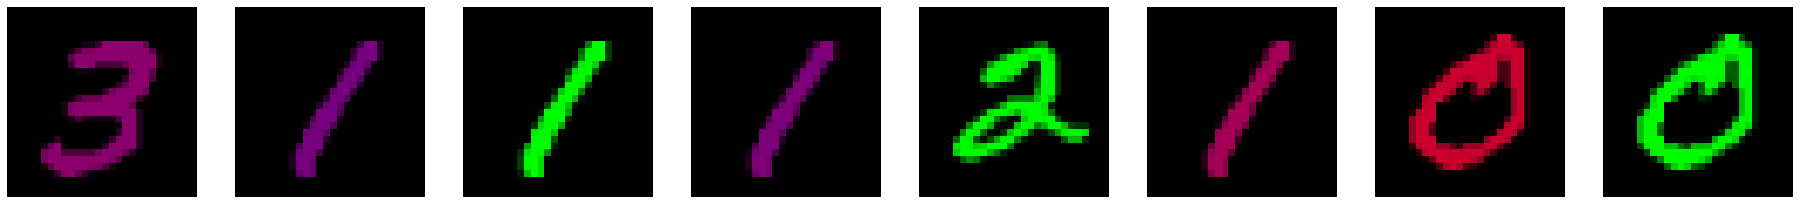

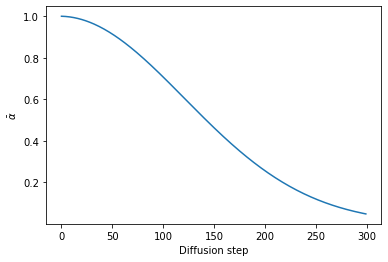

-0.81499594 0.6584031


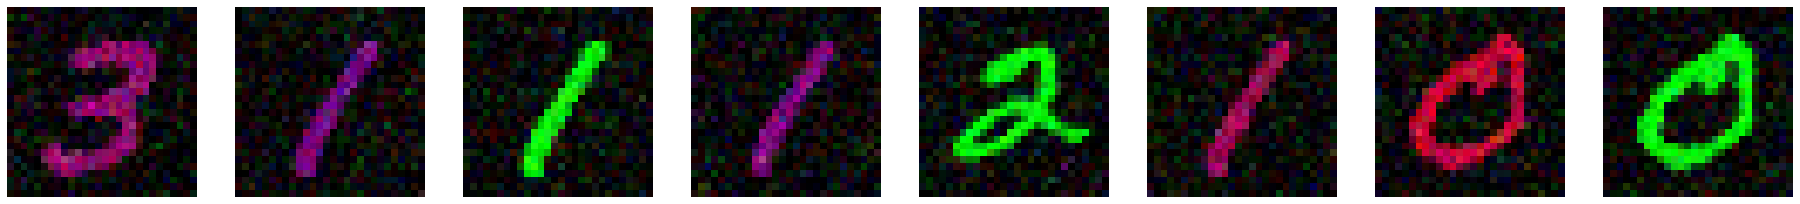

-1.5716085 1.3231856


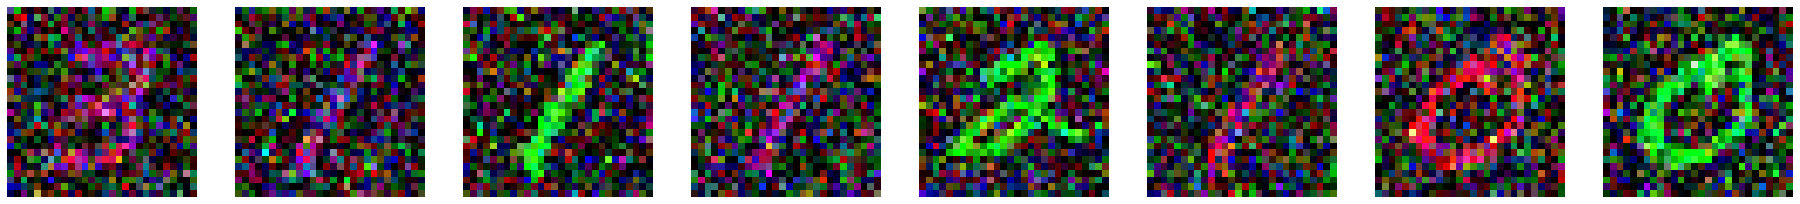

-3.244303 2.7547495


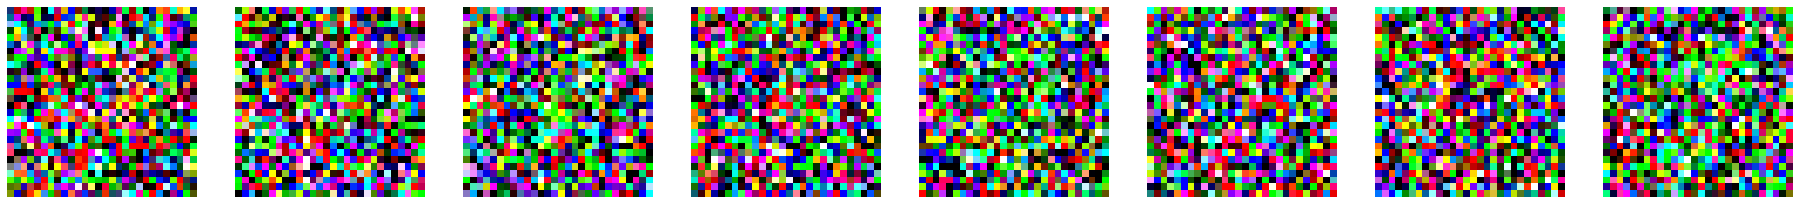

-3.8958397 3.470311


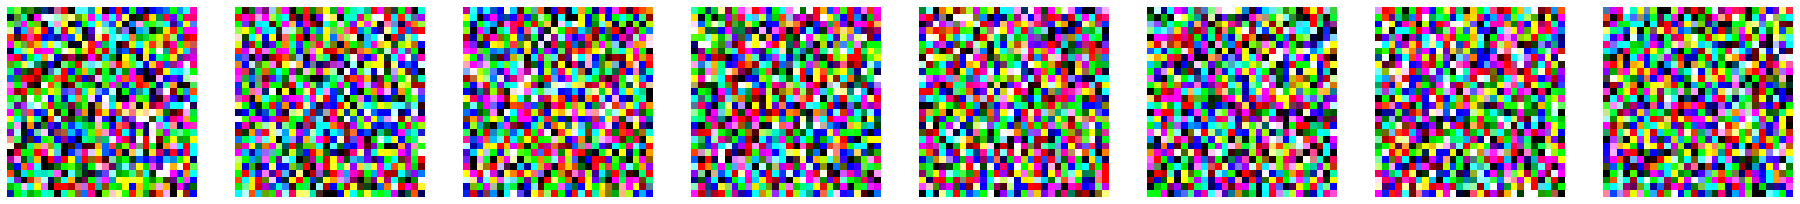

In [2]:
char_set = dataset.mnist_char_set()
global_rng = jax.random.PRNGKey(0)

# Ground Truth Images.
sub_rng, global_rng = jax.random.split(global_rng)
images, labels = dataset.mnist_shift(char_set, sub_rng, batch_size=8)
utils.plot_image_row(images + 0.5)


# Noise Schedule.
timesteps = 300
beta = jnp.linspace(0.0001, 0.02, timesteps) # Beta = The variance for each gaussian addition.
alpha = 1 - beta # Alpha = The variance for the original image.
alpha_prod = jnp.cumprod(alpha) # Alpha Product = The variance for the original image after t timesteps.

def noise(images, variance, rng):
    return jnp.sqrt(1-variance)*images + jax.random.normal(rng, shape=images.shape) * variance

@jax.jit
def noise_at_timestep(images, noise, t):
    # Alpha_Prod approaches 1->0. At high T, this is pure noise. At low T, this is pure image.
    alpha = alpha_prod[t].reshape((images.shape[0], 1, 1, 1))
    return jnp.sqrt(alpha)*images + noise * (1-alpha)
    # return images + noise

import matplotlib.pyplot as plt
plt.plot(alpha_prod)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

for t in [50, 100, 200, 299]:
    sub_rng, global_rng = jax.random.split(global_rng)
    noise = jax.random.normal(sub_rng, shape=images.shape)
    noisy_images = noise_at_timestep(images, noise, jnp.ones(images.shape[0], dtype=jnp.int32)*t)
    print(jnp.min(noisy_images), jnp.max(noisy_images))
    utils.plot_image_row(noisy_images + 0.5)



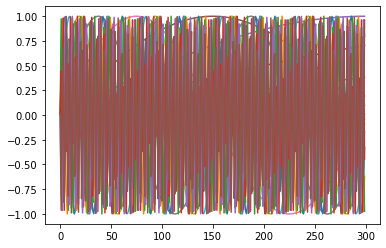

In [3]:
@jax.jit
def time_embedding(t):
    nt = t / timesteps * (jnp.pi/2)
    lis = []
    for i in range(16):
        lis.append(jnp.sin(nt*(2**(i-4))))
    return jnp.array(lis).T

# Plot graph of each embedding.
for i in range(16):
    plt.plot(time_embedding(jnp.arange(timesteps))[:,i])
plt.show()


In [4]:
model = models.DiffusionLinear()
dummy_input = jnp.zeros((1, 28, 28, 3))
dummy_input_time = jnp.zeros((1, 16))

@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
  metrics: Metrics

# Initialize the parameters, optimizer, etc.
def create_train_state(module, rng, learning_rate):
  params = module.init(rng, dummy_input, dummy_input_time)['params'] # initialize parameters by passing a template image
  tx = optax.adam(learning_rate)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

# One step of training.
# @jax.jit
def train_step(state, images, rng):
    rng1, rng2 = jax.random.split(rng)
    
    # Sample noise and times.
    random_times = jax.random.randint(rng1, shape=(images.shape[0],), minval=0, maxval=300)
    # random_times = jnp.ones((images.shape[0],), dtype=jnp.int32) * 50
    times = time_embedding(random_times)
    noise = jax.random.normal(rng2, shape=images.shape)
    noisy_images = noise_at_timestep(images, noise, random_times)

    # Run the model forward one step. Using params.
    def loss_fn(params):
        model_output = state.apply_fn({'params': params}, noisy_images, times)
        loss = optax.l2_loss(model_output, images).mean()
        return loss
    # Compute gradient and apply an optimization step.
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)

    # Log metrics. (This is inefficient but for sanity purposes)
    metric_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

# Evaluation.
def pred_step(state, rng, batch_size):
  rng1, rng2 = jax.random.split(rng)
  rng0, rng1 = jax.random.split(rng1)

  images, _ = dataset.mnist_shift(char_set, rng0, batch_size=batch_size)


  random_times = jax.random.randint(rng1, shape=(images.shape[0],), minval=0, maxval=300)
  # random_times = jnp.ones((images.shape[0],), dtype=jnp.int32) * 50
  times = time_embedding(random_times)
  noise = jax.random.normal(rng2, shape=images.shape)
  noisy_images = noise_at_timestep(images, noise, random_times)

  model_output = state.apply_fn({'params': state.params}, noisy_images, times)
  denoised = noisy_images - model_output * (1 - alpha_prod[random_times].reshape((images.shape[0], 1, 1, 1)))
  # denoised = noisy_images - model_output
  denoised_cheat = noisy_images - noise * (1 - alpha_prod[random_times].reshape((images.shape[0], 1, 1, 1)))

  utils.plot_image_row(images + 0.5)
  # utils.plot_image_row(denoised_cheat + 0.5)
  utils.plot_image_row(noisy_images + 0.5)
  utils.plot_image_row(model_output + 0.5)
  # utils.plot_image_row(denoised + 0.5)

# # Evaluation.
# def gen_step(state, rng, batch_size):
#     z = jax.random.normal(rng, shape=(batch_size, 16))
#     model_output = state.apply_fn({'params': state.params}, z, method='decode')
#     return model_output

In [5]:
# # TRAINING LOOP

# global_rng = jax.random.PRNGKey(0)
# sub_rng, global_rng = jax.random.split(global_rng)
# state = create_train_state(model, sub_rng, 3e-4)

# char_set = dataset.mnist_char_set()

# for step in tqdm(range(100*1000)):
#     sub_rng, global_rng = jax.random.split(global_rng)
#     images, labels = dataset.mnist_shift(char_set, sub_rng, batch_size=64)

#     # Run a training step. Then, run again to compute metrics.
#     sub_rng, global_rng = jax.random.split(global_rng)
#     state = train_step(state, images, sub_rng)

#     if step % 250 == 0:
#         for metric, value in state.metrics.compute().items(): # compute metrics
#             tqdm.write(f'[{step//50}] {metric}: {value:.4f}')
#         state = state.replace(metrics=state.metrics.empty())

#     if step % 500 == 0:
#         sub_rng, global_rng = jax.random.split(global_rng)
#         pred_step(state, sub_rng, batch_size=8)

# ckpt = {'model': state}
# orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
# save_args = orbax_utils.save_args_from_target(ckpt)
# orbax_checkpointer.save('saves/diffusion/', ckpt, save_args=save_args)

In [6]:
# # Save Model
# ckpt = {'model': state}
# orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
# save_args = orbax_utils.save_args_from_target(ckpt)
# orbax_checkpointer.save('saves/diffusion/', ckpt, save_args=save_args)


In [7]:

# Restore model into 'state'
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
global_rng = jax.random.PRNGKey(0)
sub_rng, global_rng = jax.random.split(global_rng)
state_template = create_train_state(model, sub_rng, 3e-4)
ckpt_template = {'model': state_template}
ckpt = orbax_checkpointer.restore('saves/diffusion/', item=ckpt_template)
state = ckpt['model']

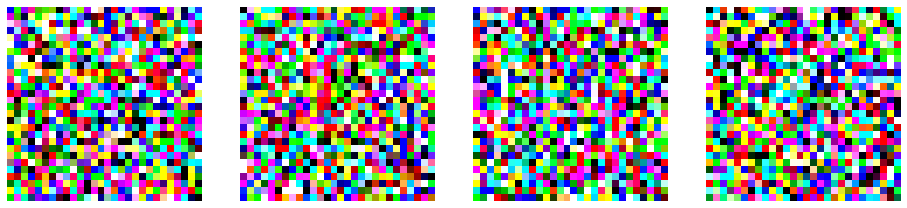

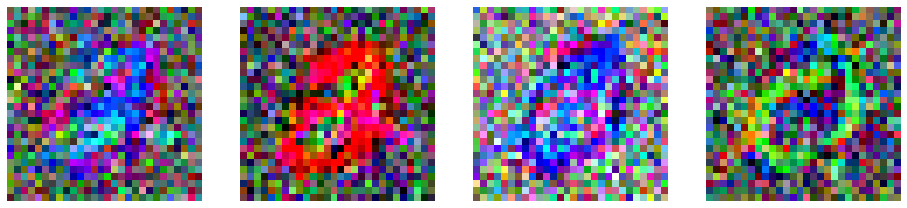

In [8]:
batch_size = 4
sub_rng, global_rng = jax.random.split(global_rng)
img = jax.random.normal(sub_rng, shape=(batch_size, 28, 28, 3))
utils.plot_image_row(img+0.5)


time_vec = jnp.ones((img.shape[0],), dtype=jnp.int32) * 280
times = time_embedding(time_vec)
pred_img = state.apply_fn({'params': state.params}, img, times)

utils.plot_image_row(pred_img+0.5)

100%|██████████| 300/300 [00:02<00:00, 113.28it/s]


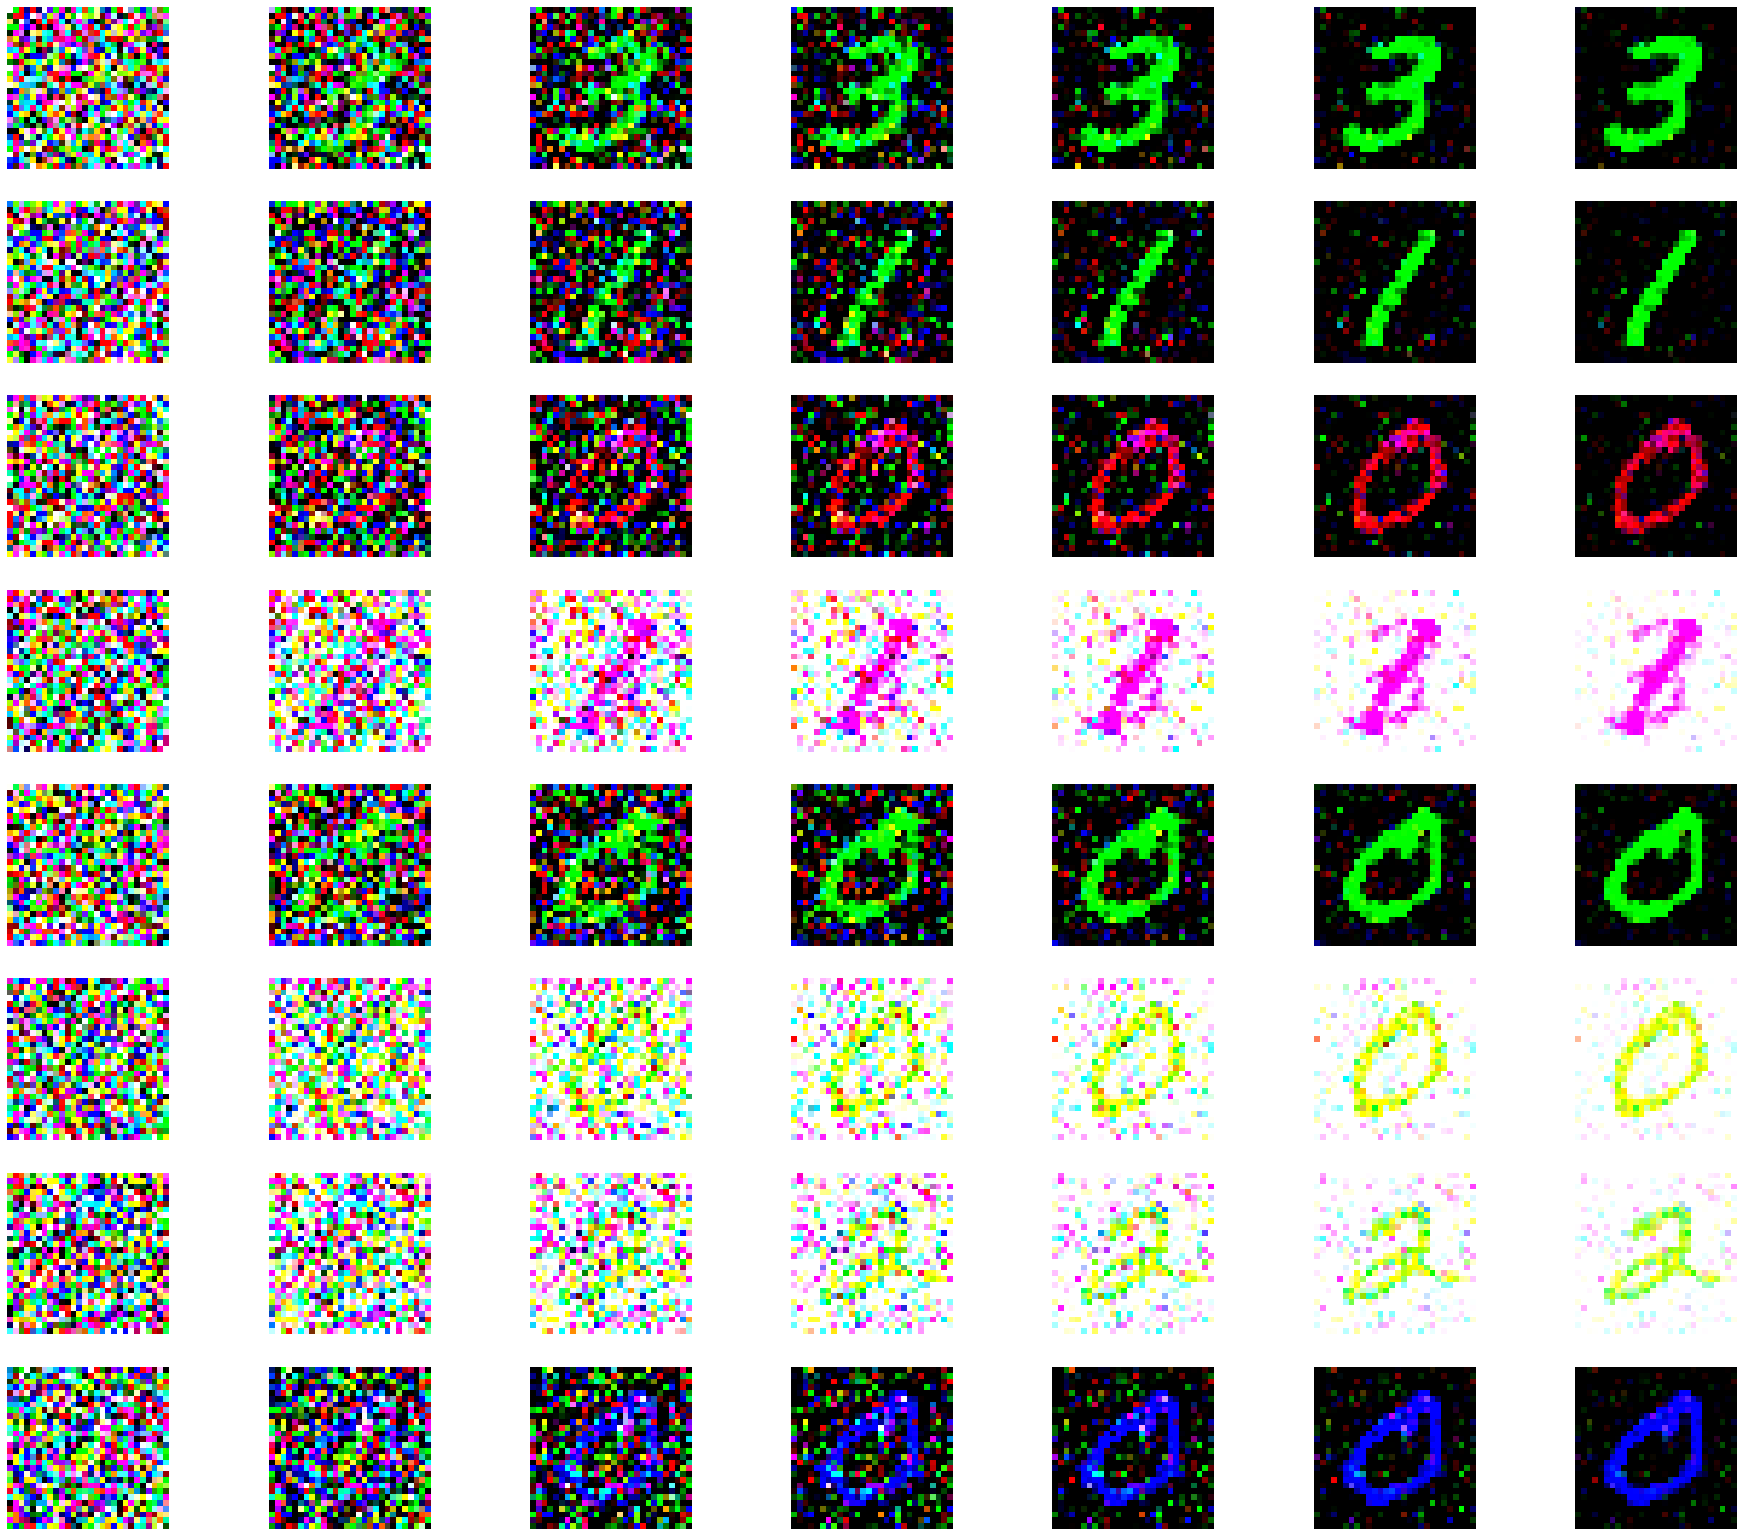

In [9]:
# Sample from model
# @jax.jit
def generate(batch_size, rng):
    alpha_prod_prev = jnp.pad(alpha_prod[:-1], (1, 0), mode='constant', constant_values=1.)
    posterior_variance = beta * (1. - alpha_prod_prev) / (1. - alpha_prod)

    # batch_size = 8
    sub_rng, rng = jax.random.split(rng)
    imgs = []
    img = jax.random.normal(sub_rng, shape=(batch_size, 28, 28, 3))
    for t in tqdm(range(timesteps)):
        ti = timesteps - t
        time_vec = jnp.ones((img.shape[0],), dtype=jnp.int32) * ti
        times = time_embedding(time_vec)

        model_pred = state.apply_fn({'params': state.params}, img, times)
        error_pred = img - model_pred

        sub_rng, rng = jax.random.split(rng)
        noise = jax.random.normal(sub_rng, shape=(batch_size, 28, 28, 3))
        img = (1/alpha[ti]) * (img - ((1-alpha[ti])/jnp.sqrt(1-alpha_prod[ti]))*error_pred) + posterior_variance[ti] * noise
        if t % 50 == 0:
            imgs.append(img)
    imgs.append(img)
    imgs = jnp.stack(imgs, axis=1)
    return imgs

imgs = generate(8, global_rng)
utils.plot_image_grid(imgs+0.5)



100%|██████████| 100/100 [00:05<00:00, 17.35it/s]


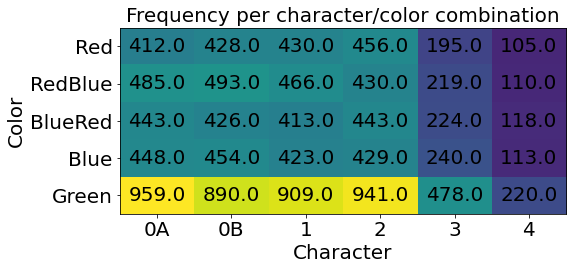

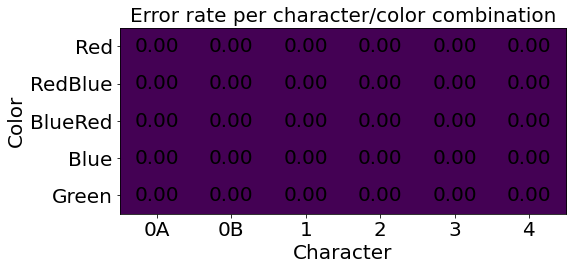

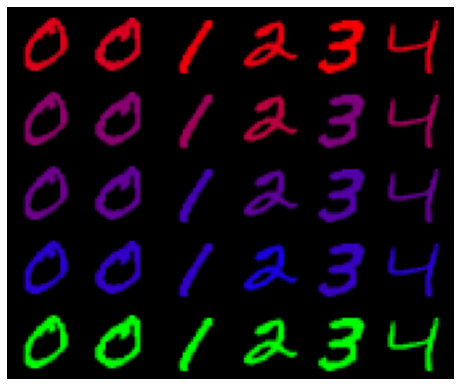

In [10]:
# Charts for Ground Truth Data

char_set = dataset.mnist_char_set()
frequency_table = jnp.zeros((5,6))
error_table = jnp.zeros((5,6))
examples_table = jnp.zeros((5,6,28,28,3))
for i in tqdm(range(100)):
    # make batch of 128 images. then categorize them. put the counts into frequency.
    sub_rng, global_rng = jax.random.split(global_rng)
    images = dataset.mnist_colored(char_set, sub_rng, batch_size=128)[0]
    chars, colors, error = dataset.categorize(char_set, images)
    frequency_table = frequency_table.at[colors, chars].add(1)
    error_table = error_table.at[colors, chars].add(error)
    examples_table = examples_table.at[colors, chars].set(images)
utils.plot_frequency_table(frequency_table)
utils.plot_error_table(error_table, frequency_table)
utils.plot_examples_table(examples_table)

100%|██████████| 300/300 [00:02<00:00, 121.22it/s]


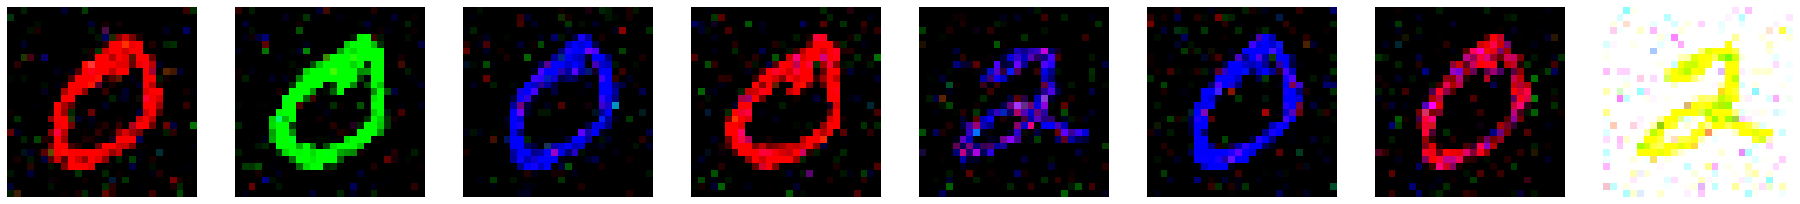

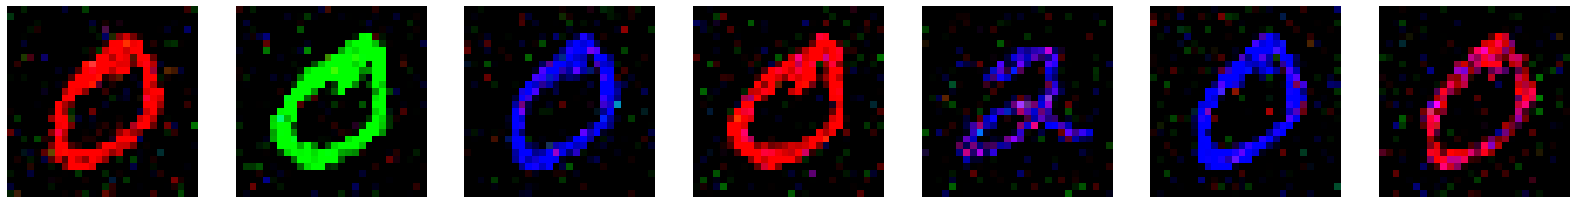

(Array([0, 1, 0, 1, 3, 0, 0], dtype=int32), Array([0, 4, 3, 0, 2, 3, 1], dtype=int32), [Array(3, dtype=int32), Array(4, dtype=int32), Array(6, dtype=int32), Array(4, dtype=int32), Array(20, dtype=int32), Array(3, dtype=int32), Array(15, dtype=int32)])


In [25]:
images = generate(8, global_rng) + 0.5
utils.plot_image_row(images[:,-1])
# utils.plot_image_grid(images)

img_row = images[:,-1]
def process_gen(images):
    new_imgs = []
    for im in images:
        if jnp.mean(im) < 0:
            new_imgs.append(im)
    return jnp.stack(new_imgs, axis=0)

processed = process_gen(img_row)
processed = jnp.clip(processed, 0, 1)
utils.plot_image_row(processed)
# print(processed[0][:14][:14])

print(dataset.categorize(char_set, processed))


100%|██████████| 100/100 [04:04<00:00,  2.45s/it]


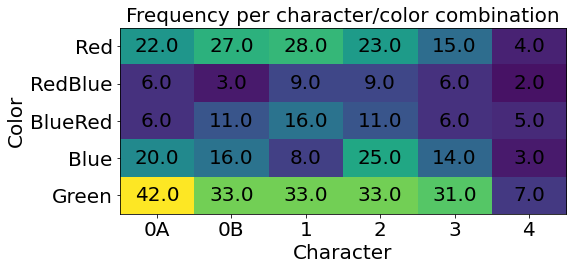

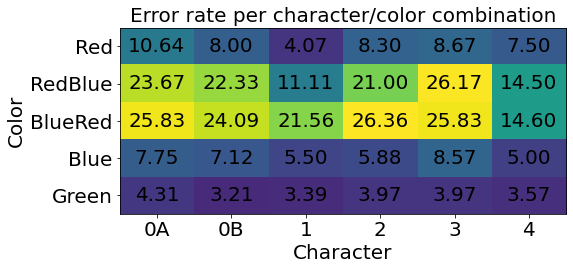

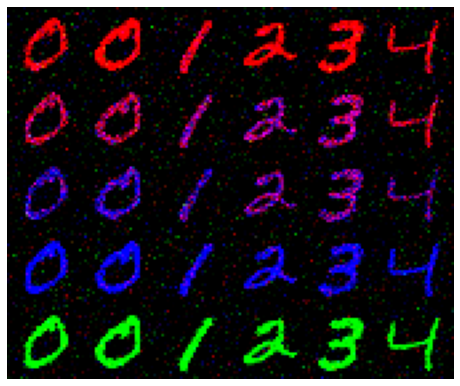

In [27]:
# Charts for Generated Data

char_set = dataset.mnist_char_set()
frequency_table = jnp.zeros((5,6))
error_table = jnp.zeros((5,6))
examples_table = jnp.zeros((5,6,28,28,3))
for i in tqdm(range(100)):
    # make batch of 128 images. then categorize them. put the counts into frequency.
    sub_rng, global_rng = jax.random.split(global_rng)

    images = process_gen(generate(128, sub_rng)[:,-1] + 0.5)
    images = jnp.clip(images, 0, 1)

    chars, colors, error = dataset.categorize(char_set, images)
    frequency_table = frequency_table.at[colors, chars].add(1)
    error_table = error_table.at[colors, chars].add(error)
    examples_table = examples_table.at[colors, chars].set(images)
utils.plot_frequency_table(frequency_table)
utils.plot_error_table(error_table, frequency_table)
utils.plot_examples_table(examples_table)

In [ ]:
utils.plot_examples_table(examples_table)